In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt
import time
from tqdm import tqdm



In [2]:
IMAGE_DIR = "images"
LABEL_FILE = "labels.txt"

NUM_ATTRS = 4
BATCH_SIZE = 16
EPOCHS = 20
LR = 1e-4

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"


In [3]:
def load_label_dict(label_file):
    label_dict = {}

    with open(label_file, "r") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue

            parts = line.split()
            if len(parts) != 5:
                continue

            img_name = parts[0]
            raw_labels = parts[1:]

            labels = []
            for val in raw_labels:
                if val == "NA":
                    labels.append(-1)
                else:
                    labels.append(int(val))

            label_dict[img_name] = torch.tensor(labels, dtype=torch.float)

    return label_dict


label_dict = load_label_dict(LABEL_FILE)
print("Total labels loaded:", len(label_dict))


Total labels loaded: 975


In [4]:
class MultiLabelDataset(Dataset):
    def __init__(self, image_dir, label_dict, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.samples = []

        image_files = os.listdir(image_dir)

        for img_name in image_files:
            if img_name in label_dict:
                self.samples.append((img_name, label_dict[img_name]))

        print(f"Total valid image-label pairs: {len(self.samples)}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_name, labels = self.samples[idx]
        img_path = os.path.join(self.image_dir, img_name)

        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        return image, labels


In [5]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

dataset = MultiLabelDataset(IMAGE_DIR, label_dict, transform)

print("Dataset length:", len(dataset))
print("Sample labels:", dataset[0][1])


Total valid image-label pairs: 972
Dataset length: 972
Sample labels: tensor([ 1., -1.,  0.,  1.])


In [6]:
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)


In [7]:
total = torch.zeros(NUM_ATTRS)
positive = torch.zeros(NUM_ATTRS)

for _, labels in dataset.samples:
    for i in range(NUM_ATTRS):
        if labels[i] != -1:
            total[i] += 1
            if labels[i] == 1:
                positive[i] += 1

pos_weight = (total - positive) / (positive + 1e-6)
pos_weight = pos_weight.to(DEVICE)

print("Positive class weights:", pos_weight)


Positive class weights: tensor([ 0.1349,  0.2408,  0.8966, 11.9412])


In [10]:
model = torchvision.models.resnet18(weights="IMAGENET1K_V1")
model.fc = nn.Linear(model.fc.in_features, NUM_ATTRS)
model = model.to(DEVICE)
# Loss function (with class imbalance handling)
criterion = nn.BCEWithLogitsLoss(reduction="none", pos_weight=pos_weight)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=LR)



In [11]:
losses = []
iteration = 0

model.train()

start_training_time = time.time()

for epoch in range(EPOCHS):
    epoch_start_time = time.time()
    running_loss = 0.0

    progress_bar = tqdm(loader, desc=f"Epoch {epoch+1}/{EPOCHS}", leave=False)

    for images, labels in progress_bar:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(images)

        mask = labels != -1
        loss = criterion(outputs, labels)
        loss = (loss * mask).sum() / mask.sum()

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        losses.append(loss.item())
        iteration += 1

        progress_bar.set_postfix({
            "batch_loss": f"{loss.item():.4f}"
        })

    epoch_time = time.time() - epoch_start_time
    avg_loss = running_loss / len(loader)

    elapsed_time = time.time() - start_training_time
    epochs_left = EPOCHS - (epoch + 1)
    est_time_left = (elapsed_time / (epoch + 1)) * epochs_left

    print(
        f"Epoch [{epoch+1}/{EPOCHS}] | "
        f"Avg Loss: {avg_loss:.4f} | "
        f"Epoch Time: {epoch_time:.2f}s | "
        f"ETA: {est_time_left/60:.2f} min"
    )


Epoch [1/20] | Avg Loss: 0.6289 | Epoch Time: 137.54s | ETA: 43.55 min


Epoch [2/20] | Avg Loss: 0.4480 | Epoch Time: 138.73s | ETA: 41.44 min


Epoch [3/20] | Avg Loss: 0.3415 | Epoch Time: 127.41s | ETA: 38.12 min


Epoch [4/20] | Avg Loss: 0.2852 | Epoch Time: 128.86s | ETA: 35.50 min


Epoch [5/20] | Avg Loss: 0.2361 | Epoch Time: 127.64s | ETA: 33.01 min


Epoch [6/20] | Avg Loss: 0.1812 | Epoch Time: 136.89s | ETA: 31.00 min


Epoch [7/20] | Avg Loss: 0.1397 | Epoch Time: 134.63s | ETA: 28.84 min


Epoch [8/20] | Avg Loss: 0.1002 | Epoch Time: 137.91s | ETA: 26.74 min


Epoch [9/20] | Avg Loss: 0.0874 | Epoch Time: 127.62s | ETA: 24.39 min


Epoch [10/20] | Avg Loss: 0.1046 | Epoch Time: 127.98s | ETA: 22.09 min


Epoch [11/20] | Avg Loss: 0.0657 | Epoch Time: 129.46s | ETA: 19.84 min


Epoch [12/20] | Avg Loss: 0.0525 | Epoch Time: 128.49s | ETA: 17.59 min


Epoch [13/20] | Avg Loss: 0.0480 | Epoch Time: 130.10s | ETA: 15.38 min


Epoch [14/20] | Avg Loss: 0.0372 | Epoch Time: 128.95s | ETA: 13.16 min


Epoch [15/20] | Avg Loss: 0.0330 | Epoch Time: 142.12s | ETA: 11.02 min


Epoch [16/20] | Avg Loss: 0.0300 | Epoch Time: 159.00s | ETA: 8.93 min


Epoch [17/20] | Avg Loss: 0.0309 | Epoch Time: 156.22s | ETA: 6.76 min


Epoch [18/20] | Avg Loss: 0.0227 | Epoch Time: 162.11s | ETA: 4.56 min


Epoch [19/20] | Avg Loss: 0.0218 | Epoch Time: 162.27s | ETA: 2.30 min


Epoch [20/20] | Avg Loss: 0.0215 | Epoch Time: 165.03s | ETA: 0.00 min


In [12]:
torch.save(model.state_dict(), "model.pth")
print("Model saved as model.pth")


Model saved as model.pth


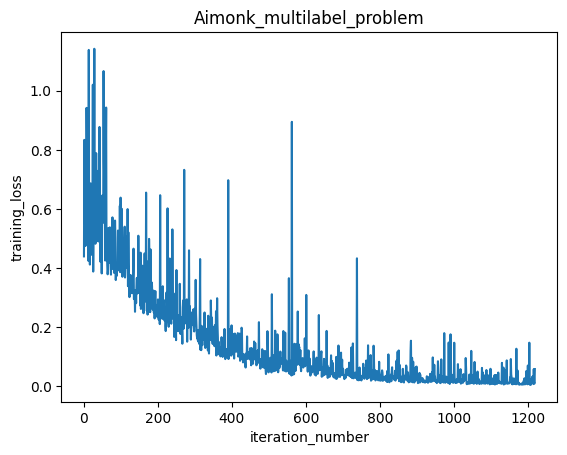

In [13]:
plt.plot(losses)
plt.xlabel("iteration_number")
plt.ylabel("training_loss")
plt.title("Aimonk_multilabel_problem")
plt.show()


In [20]:
ATTR_NAMES = ["Attr1", "Attr2", "Attr3", "Attr4"]

def predict(image_path, threshold=0.5, show_image_name=True):
    model.eval()

    # ✅ Correct way: extract name from given path
    image_name = os.path.basename(image_path)

    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        logits = model(image_tensor)
        probs = torch.sigmoid(logits)[0]

    present_attrs = [
        ATTR_NAMES[i] for i in range(NUM_ATTRS)
        if probs[i] >= threshold
    ]

    if show_image_name:
        print(f"Image: {image_name}")

    # print("Attributes present:", present_attrs)

    return present_attrs


In [21]:
predict(r"D:\Aimonk_Attribute_Classification\images\image_0.jpg")


Image: image_0.jpg


['Attr1', 'Attr2', 'Attr4']